In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import torchvision
from torchvision import transforms, models, datasets
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.nn.functional as F

import colorama
from colorama import Fore, Style

from torchsummary import summary

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'DEVICE is : {DEVICE}')

DEVICE is : cuda


In [2]:
Root_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = Root_dir + "/train"
valid_dir = Root_dir + "/valid"
test_dir = "/kaggle/input/new-plant-diseases-dataset/test"
Diseases_classes = os.listdir(train_dir)

In [3]:
cnt = 0
plant_names = []
tot_images = 0

for i in Diseases_classes:
    cnt += 1
    plant_names.append(i)
    
    image_path = os.listdir(train_dir + "/" + i)
    print(Fore.GREEN)
    print("The Number of Images in " +i+ ":", len(image_path), end= " ")
    tot_images += len(image_path)

    
    
print("\n\nTotal Number of Images in Directory: ", tot_images)


The Number of Images in Tomato___Late_blight: 1851 
The Number of Images in Tomato___healthy: 1926 
The Number of Images in Grape___healthy: 1692 
The Number of Images in Orange___Haunglongbing_(Citrus_greening): 2010 
The Number of Images in Soybean___healthy: 2022 
The Number of Images in Squash___Powdery_mildew: 1736 
The Number of Images in Potato___healthy: 1824 
The Number of Images in Corn_(maize)___Northern_Leaf_Blight: 1908 
The Number of Images in Tomato___Early_blight: 1920 
The Number of Images in Tomato___Septoria_leaf_spot: 1745 
The Number of Images in Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 1642 
The Number of Images in Strawberry___Leaf_scorch: 1774 
The Number of Images in Peach___healthy: 1728 
The Number of Images in Apple___Apple_scab: 2016 
The Number of Images in Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1961 
The Number of Images in Tomato___Bacterial_spot: 1702 
The Number of Images in Apple___Black_rot: 1987 
The Number of Images in Blueberry___heal

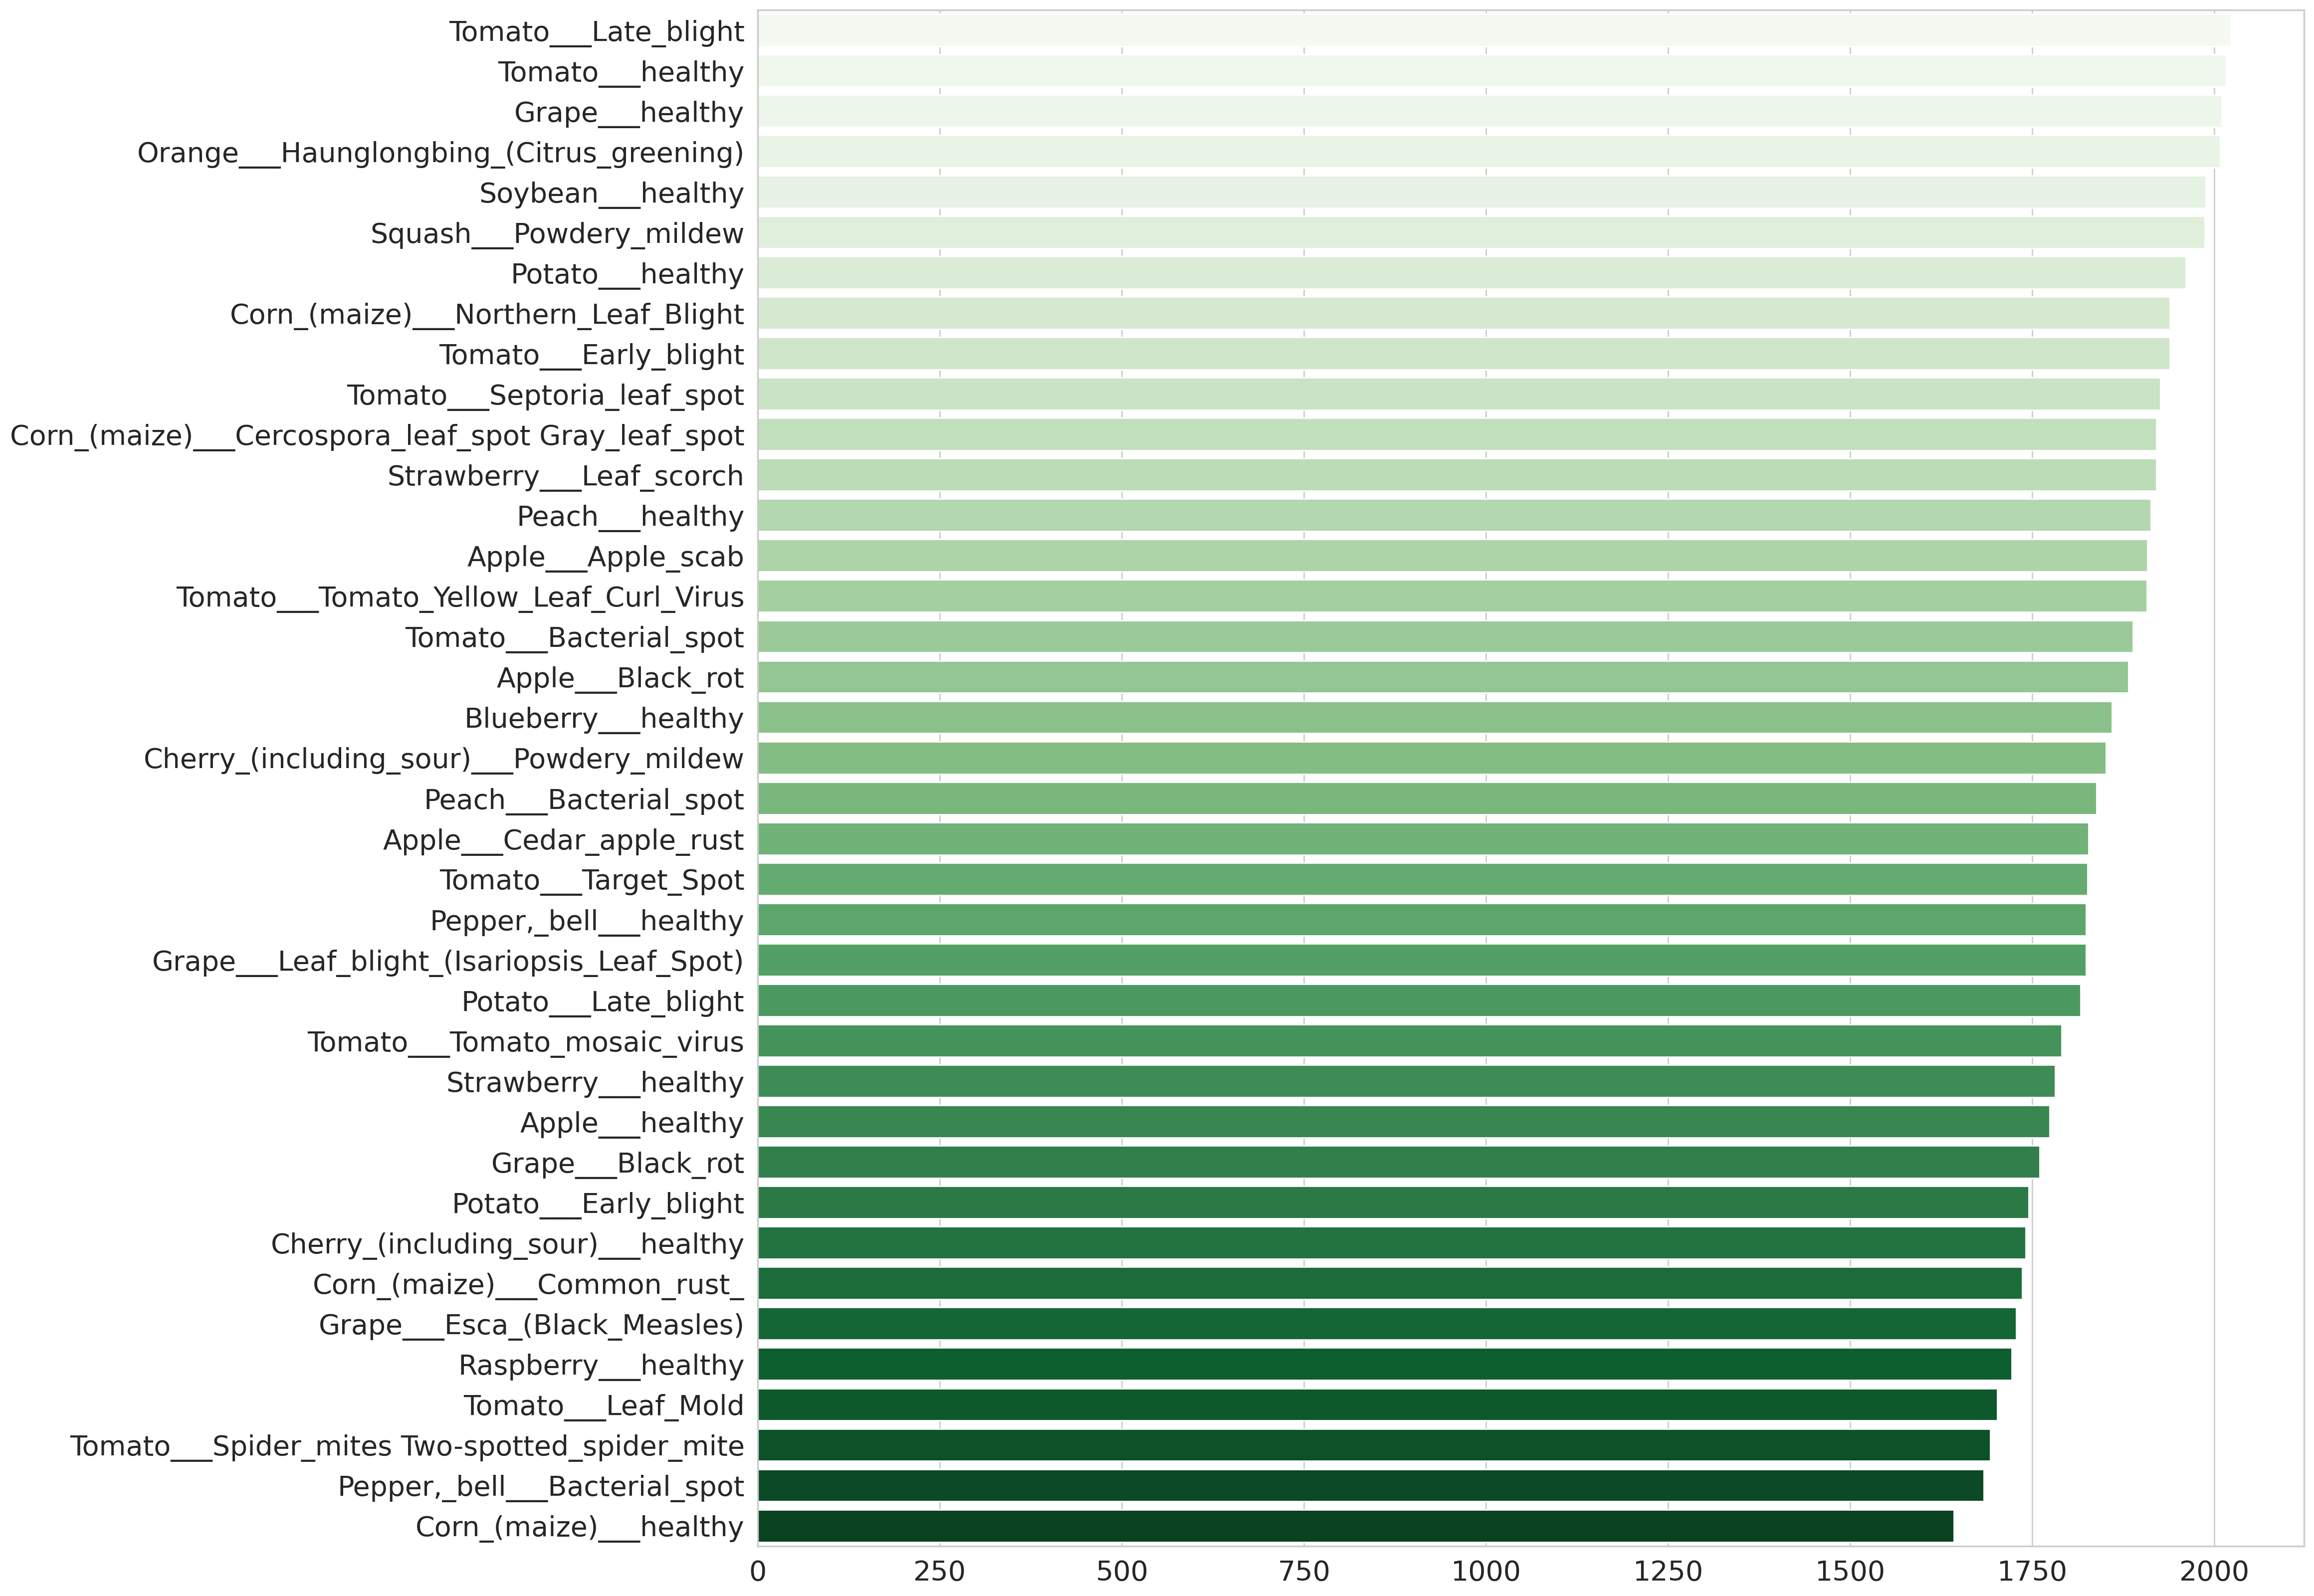

In [10]:
plant_names = []
Len = []
for i in Diseases_classes:
    plant_names.append(i)
    imgs_path = os.listdir(train_dir + "/" + i)
    Len.append(len(imgs_path))

Len.sort(reverse=True)

sns.set(style="whitegrid", color_codes=True)
plt.figure(figsize=(20,20),dpi=200)
ax = sns.barplot(x= Len, y= plant_names, palette="Greens")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # Normalize the data to [-1, 1]
])

test_transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # Normalize the data to [-1, 1]
])

val_transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # Normalize the data to [-1, 1]
])

In [5]:
train = datasets.ImageFolder(root=train_dir, transform=train_transform)
valid = datasets.ImageFolder(root=valid_dir, transform=val_transform)

In [6]:
# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [7]:
# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [8]:
batch_size = 32
# DataLoaders for training and validation
train_dataloader = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dataloader = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [9]:
# Moving data into GPU, WrappedDataLoader
train_dataloader = DeviceDataLoader(train_dataloader, DEVICE)
valid_dataloader = DeviceDataLoader(valid_dataloader, DEVICE)

In [11]:
def get_inception_model(num_classes, feature_extract=True):
    # Must use aux_logits=True when using pretrained weights
    model = models.inception_v3(pretrained=True, aux_logits=True)

    # Freeze all layers if using as feature extractor
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

    # Replace the primary classifier
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # Optional: Replace aux classifier too, though we won't use it
    if model.aux_logits:
        model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)

    return model.to(DEVICE)


In [12]:
from tqdm import tqdm

def train_model(model, train_loader, valid_loader, optimizer, criterion, num_epochs=10, model_path="best_model.pth"):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)
        for images, labels in loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)

            if isinstance(outputs, torchvision.models.InceptionOutputs):
                outputs = outputs.logits

            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix({
                'Train Loss': f"{running_loss / (total // labels.size(0)):.4f}",
                'Train Acc': f"{100 * correct / total:.2f}%"})

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_running_loss = 0.0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)

                if isinstance(outputs, torchvision.models.InceptionOutputs):
                    outputs = outputs.logits

                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_running_loss / len(valid_loader)
        val_acc = 100 * val_correct / val_total
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

        # Log to tqdm
        tqdm.write(
            f"📊 Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, "
            f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%"
        )

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), model_path)
            print(Fore.YELLOW + f"✅ Best model saved with accuracy: {best_acc:.2f}%" + Style.RESET_ALL)


AS FEATURE EXTRACTOR

In [33]:
num_classes = len(Diseases_classes)
criterion = nn.CrossEntropyLoss()

# i) Feature Extraction
print(Fore.CYAN + "Training with feature extraction (frozen base)" + Style.RESET_ALL)
model_feat = get_inception_model(num_classes, feature_extract=True)
optimizer_feat = optim.Adam(model_feat.fc.parameters(), lr=1e-3)

train_model(model_feat, train_dataloader, valid_dataloader, optimizer_feat, criterion, num_epochs=10, model_path="inception_feature_extractor.pth")


Training with feature extraction (frozen base)

Epoch 1/10


Training Loss: 0.7726, Accuracy: 80.19%


Validation Loss: 0.3012, Accuracy: 91.59%
📊 Epoch 1: Train Loss=0.7726, Train Acc=80.19%, Val Loss=0.3012, Val Acc=91.59%
✅ Best model saved with accuracy: 91.59%

Epoch 2/10


Training Loss: 0.4286, Accuracy: 86.53%


Validation Loss: 0.2268, Accuracy: 93.17%
📊 Epoch 2: Train Loss=0.4286, Train Acc=86.53%, Val Loss=0.2268, Val Acc=93.17%
✅ Best model saved with accuracy: 93.17%

Epoch 3/10


Training Loss: 0.4010, Accuracy: 87.04%


Validation Loss: 0.2035, Accuracy: 93.89%
📊 Epoch 3: Train Loss=0.4010, Train Acc=87.04%, Val Loss=0.2035, Val Acc=93.89%
✅ Best model saved with accuracy: 93.89%

Epoch 4/10


Training Loss: 0.3914, Accuracy: 87.55%


Validation Loss: 0.1965, Accuracy: 93.68%
📊 Epoch 4: Train Loss=0.3914, Train Acc=87.55%, Val Loss=0.1965, Val Acc=93.68%

Epoch 5/10


Training Loss: 0.3887, Accuracy: 87.43%


Validation Loss: 0.1967, Accuracy: 93.69%
📊 Epoch 5: Train Loss=0.3887, Train Acc=87.43%, Val Loss=0.1967, Val Acc=93.69%

Epoch 6/10


Training Loss: 0.3846, Accuracy: 87.80%


Validation Loss: 0.1853, Accuracy: 94.00%
📊 Epoch 6: Train Loss=0.3846, Train Acc=87.80%, Val Loss=0.1853, Val Acc=94.00%
✅ Best model saved with accuracy: 94.00%

Epoch 7/10


Training Loss: 0.3851, Accuracy: 87.85%


Validation Loss: 0.1794, Accuracy: 94.18%
📊 Epoch 7: Train Loss=0.3851, Train Acc=87.85%, Val Loss=0.1794, Val Acc=94.18%
✅ Best model saved with accuracy: 94.18%

Epoch 8/10


Training Loss: 0.3793, Accuracy: 88.05%


Validation Loss: 0.1921, Accuracy: 93.77%
📊 Epoch 8: Train Loss=0.3793, Train Acc=88.05%, Val Loss=0.1921, Val Acc=93.77%

Epoch 9/10


Training Loss: 0.3832, Accuracy: 88.02%


Validation Loss: 0.1716, Accuracy: 94.46%
📊 Epoch 9: Train Loss=0.3832, Train Acc=88.02%, Val Loss=0.1716, Val Acc=94.46%
✅ Best model saved with accuracy: 94.46%

Epoch 10/10


Training Loss: 0.3842, Accuracy: 88.04%


Validation Loss: 0.1627, Accuracy: 95.00%
📊 Epoch 10: Train Loss=0.3842, Train Acc=88.04%, Val Loss=0.1627, Val Acc=95.00%
✅ Best model saved with accuracy: 95.00%


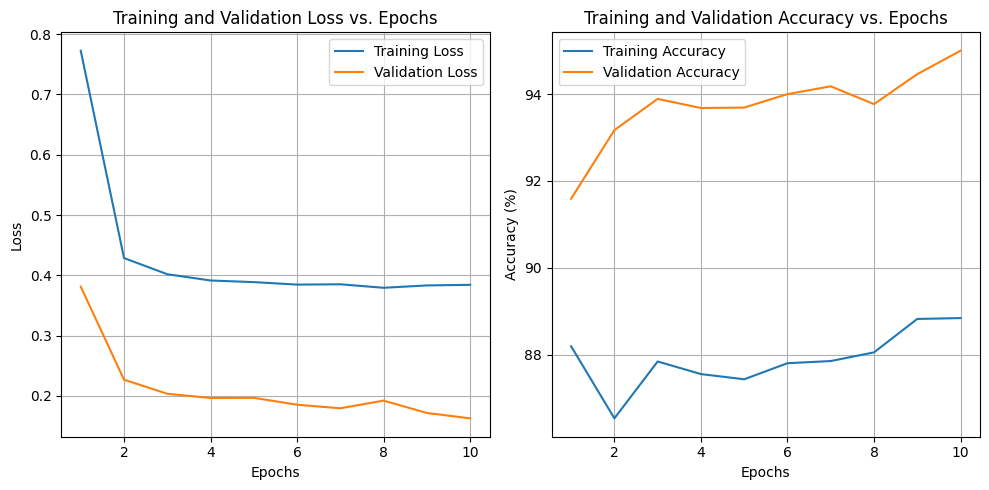

In [20]:
import matplotlib.pyplot as plt

# Pre-defined lists of values
epochs = list(range(1, 11))  # Assuming 10 epochs
training_losses = [0.7726, 0.4286, 0.4018, 0.3914, 0.3887, 0.3846, 0.3851, 0.3793, 0.3832, 0.3842]
validation_losses = [0.3812, 0.2268, 0.2035, 0.1965, 0.1967, 0.1853, 0.1794, 0.1921, 0.1716, 0.1627]
training_accuracies = [88.19, 86.53, 87.84, 87.55, 87.43, 87.80, 87.85, 88.05, 88.82, 88.84]
validation_accuracies = [91.59, 93.17, 93.89, 93.68, 93.69, 94.00, 94.18, 93.77, 94.46, 95.00]

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.legend()
plt.grid(True)

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracies, label='Training Accuracy')
plt.plot(epochs, validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy vs. Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


✅ Validation Accuracy: 95.00%

📋 Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.94      0.96      0.95       504
                                 Apple___Black_rot       0.97      0.98      0.97       497
                          Apple___Cedar_apple_rust       0.94      1.00      0.97       440
                                   Apple___healthy       0.98      0.96      0.97       502
                               Blueberry___healthy       1.00      0.98      0.99       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.98      0.99       421
                 Cherry_(including_sour)___healthy       0.99      1.00      0.99       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.87      0.91       410
                       Corn_(maize)___Common_rust_       1.00      0.99      0.99       477
               Corn_(m

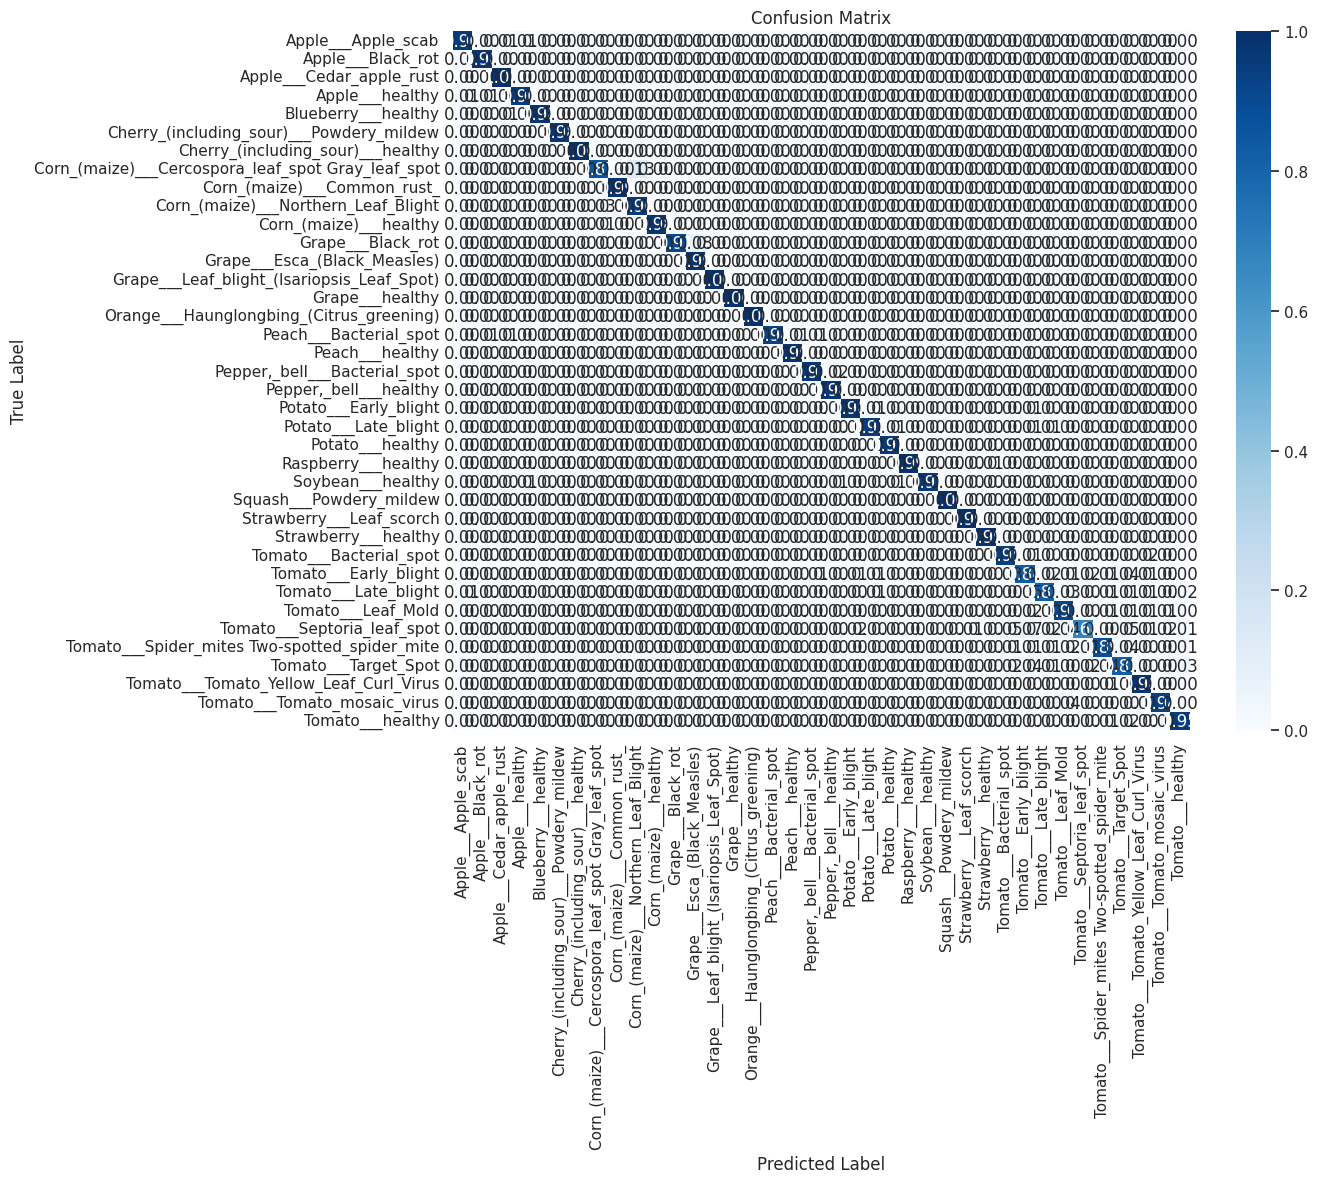

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

def evaluate_and_plot(model, valid_loader, class_names, model_path=None, normalize=True):
    if model_path:
        model.load_state_dict(torch.load(model_path))

    model.to(DEVICE)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)

            # Handle InceptionOutput
            if isinstance(outputs, torchvision.models.InceptionOutputs):
                outputs = outputs.logits

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy and classification report
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
    print(f"\n✅ Validation Accuracy: {accuracy:.2f}%")
    print("\n📋 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'

    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# If using ImageFolder or a dataset with .class_to_idx:
idx_to_class = {v: k for k, v in train.class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

evaluate_and_plot(model_feat, valid_dataloader, class_names, model_path="inception_feature_extractor.pth")
num_classes = len(Diseases_classes)
criterion = nn.CrossEntropyLoss()

FINE-TUNING THE WHOLE MODEL

In [15]:
num_classes = len(Diseases_classes)
criterion = nn.CrossEntropyLoss()

# ii) Fine-Tuning
print(Fore.CYAN + "\nTraining with fine-tuning (unfreeze upper layers)" + Style.RESET_ALL)
model_ft = get_inception_model(num_classes, feature_extract=False)
# You may want to tune this optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-4)

train_model(model_ft, train_dataloader, valid_dataloader, optimizer_ft, criterion, num_epochs=5, model_path="inception_finetuned.pth")


Training with fine-tuning (unfreeze upper layers)

Epoch 1/5


Training Loss: 0.2092, Accuracy: 95.15%


Validation Loss: 0.0297, Accuracy: 99.02%
📊 Epoch 1: Train Loss=0.2092, Train Acc=95.15%, Val Loss=0.0297, Val Acc=99.02%
✅ Best model saved with accuracy: 99.02%

Epoch 2/5


Training Loss: 0.0383, Accuracy: 98.93%


Validation Loss: 0.0210, Accuracy: 99.28%
📊 Epoch 2: Train Loss=0.0383, Train Acc=98.93%, Val Loss=0.0210, Val Acc=99.28%
✅ Best model saved with accuracy: 99.28%

Epoch 3/5


Training Loss: 0.0271, Accuracy: 99.20%


Validation Loss: 0.0563, Accuracy: 98.38%
📊 Epoch 3: Train Loss=0.0271, Train Acc=99.20%, Val Loss=0.0563, Val Acc=98.38%

Epoch 4/5


Training Loss: 0.0210, Accuracy: 99.38%


Validation Loss: 0.0318, Accuracy: 99.10%
📊 Epoch 4: Train Loss=0.0210, Train Acc=99.38%, Val Loss=0.0318, Val Acc=99.10%

Epoch 5/5


Training Loss: 0.0185, Accuracy: 99.46%


Validation Loss: 0.0118, Accuracy: 99.62%
📊 Epoch 5: Train Loss=0.0185, Train Acc=99.46%, Val Loss=0.0118, Val Acc=99.62%
✅ Best model saved with accuracy: 99.62%


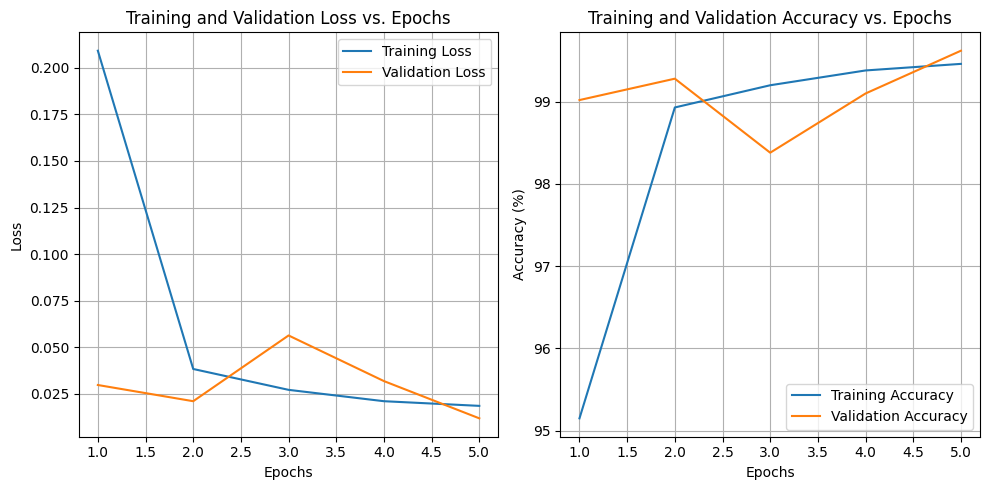

In [21]:
import matplotlib.pyplot as plt

# Pre-defined lists of values for the new model
epochs = list(range(1, 6))  # 5 epochs
training_losses = [0.2092, 0.0383, 0.0271, 0.0210, 0.0185]
validation_losses = [0.0297, 0.0210, 0.0563, 0.0318, 0.0118]
training_accuracies = [95.15, 98.93, 99.20, 99.38, 99.46]
validation_accuracies = [99.02, 99.28, 98.38, 99.10, 99.62]

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.legend()
plt.grid(True)

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracies, label='Training Accuracy')
plt.plot(epochs, validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy vs. Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


✅ Validation Accuracy: 99.62%

📋 Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00       504
                                 Apple___Black_rot       1.00      1.00      1.00       497
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       440
                                   Apple___healthy       1.00      1.00      1.00       502
                               Blueberry___healthy       1.00      1.00      1.00       454
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       421
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.97      0.97       410
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       477
               Corn_(m

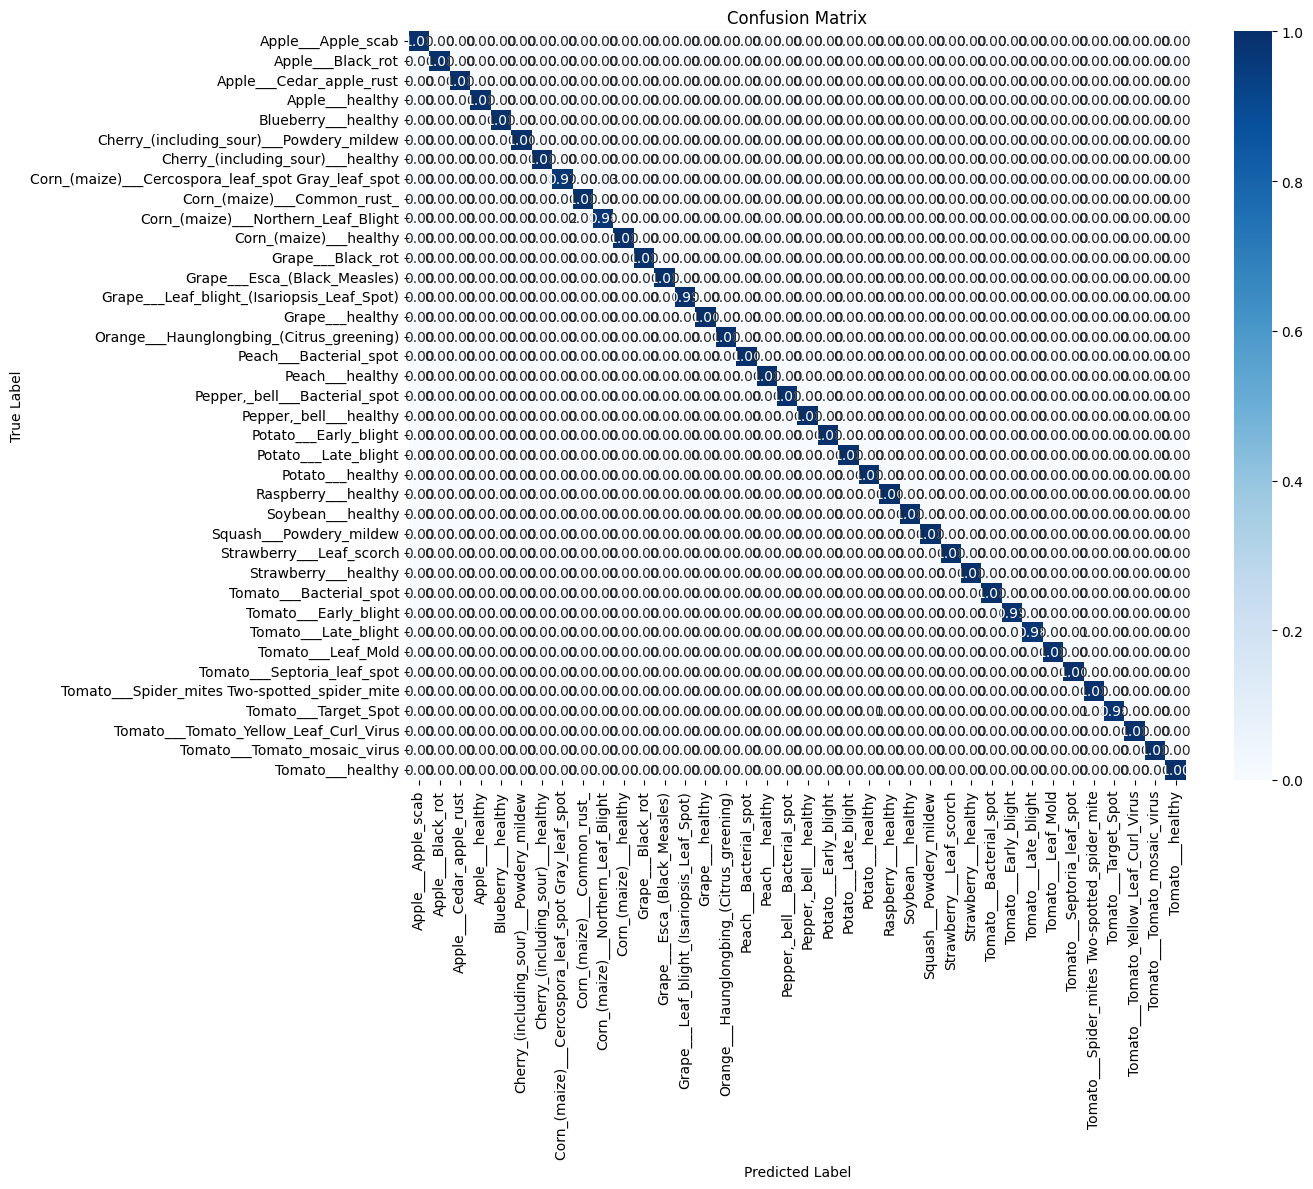

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

def evaluate_and_plot(model, valid_loader, class_names, model_path=None, normalize=True):
    if model_path:
        model.load_state_dict(torch.load(model_path))

    model.to(DEVICE)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)

            # Handle InceptionOutput
            if isinstance(outputs, torchvision.models.InceptionOutputs):
                outputs = outputs.logits

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy and classification report
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
    print(f"\n✅ Validation Accuracy: {accuracy:.2f}%")
    print("\n📋 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'

    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# If using ImageFolder or a dataset with .class_to_idx:
idx_to_class = {v: k for k, v in train.class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

evaluate_and_plot(model_ft, valid_dataloader, class_names, model_path="/kaggle/working/inception_finetuned.pth")
